#Loading the libraries

In [41]:
import numpy as np
import pandas as pd


#Mounting drive in colab

In [42]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#unzip dataset

In [43]:
!unzip '/content/drive/My Drive/Colab Notebooks/CTMLProj/archiveData.zip'


Archive:  /content/drive/My Drive/Colab Notebooks/CTMLProj/archiveData.zip
replace sign_data/sign_data/test/049/01_049.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sign_data/sign_data/test/049/01_049.png  
  inflating: sign_data/sign_data/test/049/02_049.png  
  inflating: sign_data/sign_data/test/049/03_049.png  
  inflating: sign_data/sign_data/test/049/04_049.png  
  inflating: sign_data/sign_data/test/049/05_049.png  
  inflating: sign_data/sign_data/test/049/06_049.png  
  inflating: sign_data/sign_data/test/049/07_049.png  
  inflating: sign_data/sign_data/test/049/08_049.png  
  inflating: sign_data/sign_data/test/049/09_049.png  
  inflating: sign_data/sign_data/test/049/10_049.png  
  inflating: sign_data/sign_data/test/049/11_049.png  
  inflating: sign_data/sign_data/test/049/12_049.png  
  inflating: sign_data/sign_data/test/049_forg/01_0114049.PNG  
  inflating: sign_data/sign_data/test/049_forg/01_0206049.PNG  
  inflating: sign_data/sign_data/test/049_forg/0

#Load train and test data

In [44]:
train_dir="/content/sign_data/sign_data/train/"
test_dir="/content/sign_data/sign_data/test/"


#visualise a train data sample

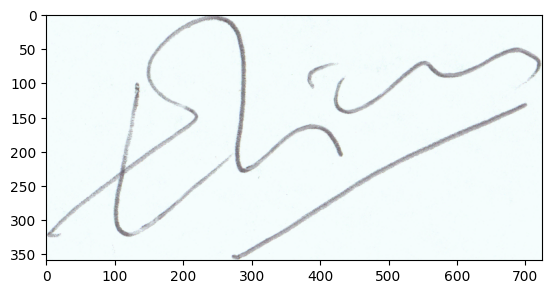

In [45]:
import matplotlib.pyplot as plt
img = plt.imread('/content/sign_data/sign_data/train/001/001_01.PNG')
plt.imshow(img)


#Visualise another train data sample

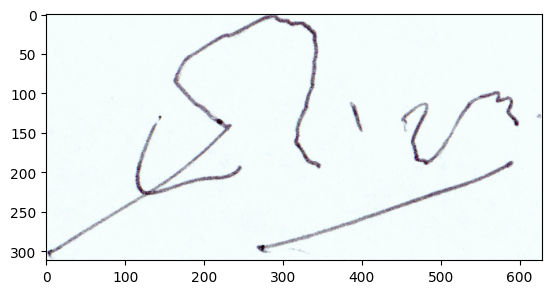

In [46]:
img1 = plt.imread('/content/sign_data/sign_data/train/001_forg/0119001_01.png')
plt.imshow(img1)


#Define barch size

In [47]:
SIZE = 224


# Loading and preparing the data

In [48]:
import cv2
import os
import glob

train_data = []
train_labels = []

for per in os.listdir('/content/sign_data/sign_data/train/'):
    for data in glob.glob('/content/sign_data/sign_data/train/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        train_data.append([img])
        if per[-1]=='g':
            train_labels.append(np.array(1))
        else:
            train_labels.append(np.array(0))

train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)


#Test Data

In [49]:

test_data = []
test_labels = []

for per in os.listdir('/content/sign_data/sign_data/test/'):
    for data in glob.glob('/content/sign_data/sign_data/test/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        test_data.append([img])
        if per[-1]=='g':
            test_labels.append(np.array(1))
        else:
            test_labels.append(np.array(0))

test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)


#converting train data to categorical data

In [50]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)


#Checking train data size

In [51]:
train_data.shape


(1649, 1, 224, 224, 3)

#Reshaping train/test data

In [52]:
train_data = train_data.reshape(-1, SIZE,SIZE, 3)
test_data = test_data.reshape(-1, SIZE,SIZE, 3)


#Checking new shape of train data

In [53]:
train_data.shape


(1649, 224, 224, 3)

#Train data labels shape - Original or Forged labels

In [54]:
train_labels.shape


(1649, 2)

#shuffle train and test data

In [55]:
from sklearn.utils import shuffle
train_data,train_labels = shuffle(train_data,train_labels)
test_data,test_labels = shuffle(test_data,test_labels)


#Transfer learning using VGG16 pre-trained on ImageNet dataset and adding new layers on top for Signature-Verification Dataset

In [56]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import Adam

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.5))  # Add a Dropout layer for regularization
add_model.add(Dense(128, activation='relu'))  # Add another Dense layer
add_model.add(Dense(64, activation='relu'))  # Add one more Dense layer
add_model.add(Dense(2, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#Define stopping condition to stop model training

In [57]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]


EPOCHS = 20
BS = 64       #Batch Size


# Train the model for the new layers added

#progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)

#model.save("HC_SignForg3.h5")

#Save model

In [58]:

from keras.models import model_from_json


# Load the model architecture from JSON

In [59]:
json_file_path = '/content/HC_SignForg3.json'
with open(json_file_path, 'r') as json_file:
    loaded_model_json = json_file.read()


# Create the model from the loaded JSON

In [60]:
loaded_model = model_from_json(loaded_model_json)


# Load the model weights

In [61]:
loaded_model.load_weights('/content/HC_SignForg3_weights.h5')

import tensorflow as tf


# Load the saved model

In [62]:
model = loaded_model


#Save the training/Validation loss values for each epoch in pickle file

In [63]:
import pickle


#history = {

 #   'accuracy': progess.history['accuracy'],

  #  'val_accuracy': progess.history['val_accuracy'],

    #'loss': progess.history['loss'],

 #   'val_loss': progess.history['val_loss']

#}

#with open('training_history.pkl', 'wb') as file:

   # pickle.dump(history, file)

# Plotting the training history

#acc = history['accuracy']

#val_acc = history['val_accuracy']

#loss = history['loss']

#val_loss = history['val_loss']

In [30]:

epochs = range(1,14)




# Load the saved history for train/val loss values

In [64]:
with open('/content/training_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)


#Plot Train/Validation Loss and Accuracies for each epoch

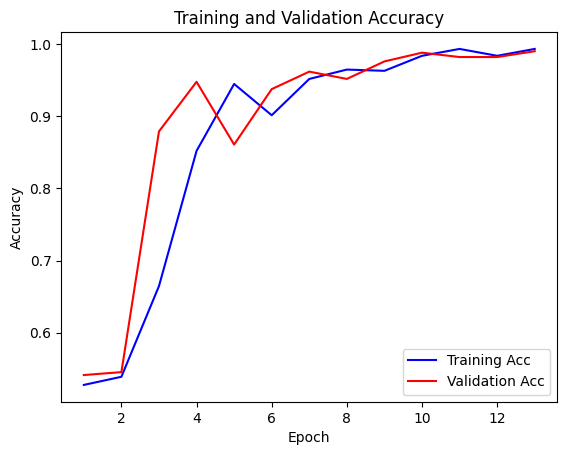

In [65]:
import matplotlib.pyplot as plt


acc = loaded_history['accuracy']
val_acc = loaded_history['val_accuracy']
loss = loaded_history['loss']
val_loss = loaded_history['val_loss']

plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'r', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#plt.savefig('accuracy_vgg2.jpg')

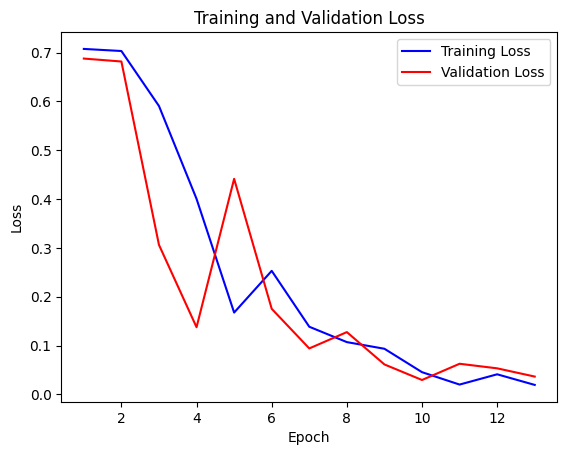

In [66]:

plt.show()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



#plt.savefig('loss_vgg.jpg')

In [67]:
plt.show()


#Make predictions using the trained model

In [68]:
pred = model.predict(test_data)


16/16 [==============================] - 267s 17s/step


#Evaluate Test Accuracy

In [69]:
from sklearn.metrics import accuracy_score
print('Test Accuracy : ',accuracy_score(np.argmax(pred,axis=1), test_labels)*100, '%')


Test Accuracy :  99.6 %


# Make predictions on the test set

In [70]:
import matplotlib.pyplot as plt
import numpy as np

test_predictions = model.predict(test_data)


16/16 [==============================] - 258s 16s/step


#Predict the class of Test images using the trained model, and visualise the results

# Define class names

In [71]:
print(test_predictions)
class_names = ["Original", "Forged"]


[[9.99967158e-01 3.27581365e-05]
 [4.04860912e-05 9.99959409e-01]
 [9.99953806e-01 4.60841729e-05]
 [9.99917328e-01 8.26420364e-05]
 [9.99840260e-01 1.59725096e-04]
 [9.99994218e-01 5.70957354e-06]
 [1.14210788e-03 9.98857856e-01]
 [9.99996006e-01 3.93693290e-06]
 [9.99803543e-01 1.96502806e-04]
 [3.81463605e-13 9.99999940e-01]
 [8.60880562e-07 9.99999106e-01]
 [1.90030419e-14 9.99999940e-01]
 [9.37824836e-07 9.99998987e-01]
 [1.04682473e-14 9.99999940e-01]
 [9.99986351e-01 1.35304772e-05]
 [1.32962018e-02 9.86703753e-01]
 [3.55254529e-14 9.99999940e-01]
 [9.99997795e-01 2.17424918e-06]
 [9.99024689e-01 9.75307717e-04]
 [9.99949992e-01 4.98875415e-05]
 [9.99942482e-01 5.74378537e-05]
 [4.22775842e-10 9.99999940e-01]
 [8.24346625e-06 9.99991715e-01]
 [2.44134699e-14 9.99999940e-01]
 [9.99982178e-01 1.77607235e-05]
 [9.99986708e-01 1.32402110e-05]
 [9.99997914e-01 2.07061134e-06]
 [3.44069049e-05 9.99965489e-01]
 [1.09477674e-13 9.99999940e-01]
 [1.22078245e-05 9.99987781e-01]
 [3.147425

# Choose some random samples to display

In [72]:
num_samples_to_display = 5
random_indices = np.random.choice(len(test_data), num_samples_to_display, replace=False)


# Display the images along with their predictions

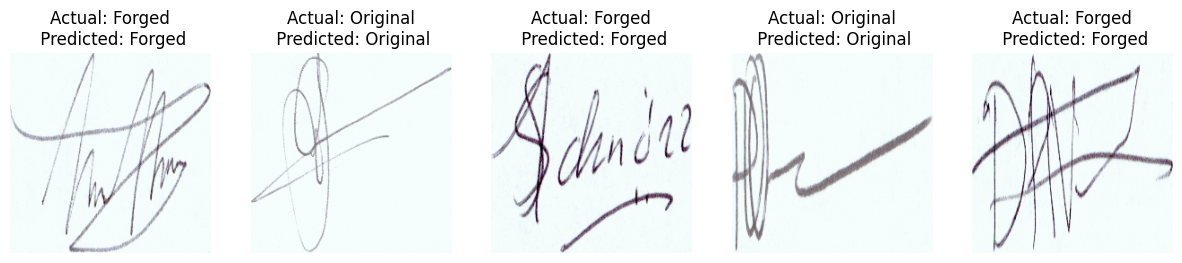

In [73]:
plt.figure(figsize=(15, 5))

for i, index in enumerate(random_indices, 1):
    plt.subplot(1, num_samples_to_display, i)
    plt.imshow(test_data[index])

    actual_class = class_names[int(test_labels[index])]
    predicted_class = class_names[np.argmax(test_predictions[index])]

    plt.title(f'Actual: {actual_class}\n Predicted: {predicted_class}')
    plt.axis('off')

plt.show()